In [1]:
!pip install mahotas
!pip install SimpleITK

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.5/34.5 MB 21.9 MB/s eta 0:00:00m eta 0:00:010:01:02
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Discarding https://files.pythonhosted.org/packages/03/c1/20fc2c50ab1e3304da36d866042a1905a2b05a1431ece35448ab6b4578f2/pyradiomics-3.1.0.tar.gz (from https://pypi.org/simple/pyradiomics/): Requested pyradiomics from https://files.pythonhosted.org/packages/03/c1/20fc2c50ab1e3304da36d866042a1905a2b05a1431ece35448ab6b4578f2/pyradiomics-3.1.0.tar.gz has inconsistent version: expected '3.1.0', but metadata has '3.0.1a1'
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.5/34.5 MB 47.4 MB/s eta 0:00:00 MB/s eta 0:00:01:01
  Preparing metadata (setup.py) ... error
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [30 lines of output]
      /tmp/pip-install-2gqcdi80/pyradiomics_d35094b2af244c1481a

In [5]:
!pip install "scikit-image==0.25"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.0/15.0 MB 32.0 MB/s eta 0:00:0031m31.2 MB/s eta 0:00:01
  Attempting uninstall: scikit-image
    Found existing installation: scikit-image 0.24.0
    Uninstalling scikit-image-0.24.0:
      Successfully uninstalled scikit-image-0.24.0


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from skimage.measure import label, regionprops, regionprops_table
import skimage
from scipy.signal import convolve2d, medfilt2d, convolve
from scipy.ndimage.filters import generic_filter
from skimage.filters import sobel_h, sobel_v, sobel
from skimage.filters.rank import gradient,mean
from skimage.morphology import erosion,dilation, footprint_rectangle
from skimage.util import img_as_uint, img_as_ubyte
import mahotas

/tmp/ipykernel_44729/2886931342.py:7: DeprecationWarning: Please import `generic_filter` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import generic_filter


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
def boundingbox2(vol, mask=[], n=[],slice_opt=None,disp_opt=None):
  min_col = 1000000
  min_row = 1000000
  max_col = 0
  max_row = 0

  # make all zero values in the original volume nonzero

  volcopy = vol

  minval = np.max(vol.ravel())/10000
  vol[vol == 0] = minval

  if len(mask)>1: #use the mask to create a bounding box:
    if np.shape(np.unique(mask))[0]>2:
      print('************ Provided mask is not binary ***************\n' )
      return []

    elif len(np.shape(mask))<3:
      print('Provided binary mask')
      label_img = label(mask)
      regions = skimage.measure.regionprops(label_img)
      for props in regions:
        minr, minc, maxr, maxc = props.bbox
        if min_col>minc:
          min_col=minc

        if min_row>minr:
          min_row=minr


        if max_col<maxc:
          max_col=maxc

        if max_row<maxr:
          max_row=maxr
      croppedV = volcopy[min_row-n:max_row+n,min_col-n:max_col+n]
      croppedM = mask[min_row-n:max_row+n,min_col-n:max_col+n]

    else:
      for sl in range(np.shape(mask)[2]):
        label_img = label(mask[:,:,sl])
        regions = skimage.measure.regionprops(label_img)
        for props in regions:
          minr, minc, maxr, maxc = props.bbox
          if min_col>minc:
            min_col=minc

          if min_row>minr:
            min_row=minr


          if max_col<maxc:
            max_col=maxc

          if max_row<maxr:
            max_row=maxr
        croppedV[:,:,sl] = volcopy[min_row-n:max_row+n,min_col-n:max_col+n]
        croppedM[:,:,sl] = mask[min_row-n:max_row+n,min_col-n:max_col+n]

  else: #use the image volume to create a bounding box:
    print('Cropping the image...')
    ### For testing puprposes
    # print(minval)
    # plt.imshow(vol>minval)
    # plt.show()
    vol_mask = vol>minval
    label_img = label(vol_mask)
    regions = skimage.measure.regionprops(label_img)
    for props in regions:
      minr, minc, maxr, maxc = props.bbox
      if min_col>minc:
        min_col=minc

      if min_row>minr:
        min_row=minr


      if max_col<maxc:
        max_col=maxc

      if max_row<maxr:
        max_row=maxr

    croppedV = volcopy[min_row-n:max_row+n,min_col-n:max_col+n]
    croppedM = mask[min_row-n:max_row+n,min_col-n:max_col+n]

  return croppedV,croppedM

In [4]:
## extract2DFeatIntensities subfunction
def extract2DFeatIntensities(featVol, mask, vals=1):

  # %INPUTS
  # % featVol = 3-D volume of texture features
  # % mask = 2-D annotation image
  # % vals = vector of mask values to find intensities within

  # % OUTPUT
  # % varargout = cell array(s) of intensities. Number based on length of vals
  print('\n\tExtracting requested features\n')
  joinFeat = []
  joinFeat = pd.DataFrame(joinFeat)
  if (not featVol.all) or (not mask.all) or (not vals):
        return []

  if len(np.shape(featVol)) > 2:
    print(len(np.shape(mask)))
    if len(np.shape(mask)) < 3:
      print('Generating feature vector(s) for the same mask shaped ',np.shape(joinFeat),type(joinFeat))
      for i in range(np.shape(featVol)[2]): # loop through all features
        f = featVol[:,:,i] #single feature volume
        joinFeat = pd.concat([joinFeat,pd.DataFrame(f[mask==vals].ravel(order='F'))], axis=0)
    else:
      print('Generating feature vector(s) for corresponding masks shaped',np.shape(joinFeat),type(joinFeat))
      for i in range(np.shape(featVol)[2]): # loop through all features
        f = featVol[:,:,i] #single feature volume
        m = mask[:,:,i]
        joinFeat = pd.concat([joinFeat,pd.DataFrame(f[m==vals].ravel(order='F'))], axis=0)

  else:
    print('Extracting single feature matrix')
    f = featVol #single feature volume
    for j in range(vals):# loop through all mask values
      joinFeat = f[mask==vals].ravel(order='F')
  #   print(f,'\n',joinFeat)
  # print(np.shape(joinFeat))
  return joinFeat


In [5]:
def rangefilt(I,window):
  if I.dtype in ['uint8','uint16']:
    kernel= footprint_rectangle((window,window))
    imgOutput = gradient(I,kernel)
    #print('Rangefilt output',imgOutput)
  else:
    Im=I.astype(np.uint8)
    kernel= footprint_rectangle((window,window))
    imgOutput = gradient(Im,kernel)
    #print('Rangefilt output',imgOutput)

  return imgOutput

In [6]:
def grayfilts2(img,WindowSize):
  print(':::::::::::::::::::::::::')
  grayFilt = []
  grayFilt = pd.DataFrame(grayFilt)
  imShape = np.shape(img)
  if len(imShape)>2:
    print('Only 2D images supported, see GRAYFILTS3 otherwise.\n')
    return ()
  else:
    # Calculating Mean image
    print('Calculating Mean Image.\n')
    kernel = np.ones([WindowSize,WindowSize])/(WindowSize*WindowSize)
    filtResult = convolve2d(img, kernel, mode='same')
    grayFilt = pd.concat([grayFilt,pd.DataFrame(filtResult)])

    # Calculating Median image
    print('Calculating Median Image.\n')
    filtResult = medfilt2d(img,kernel_size=WindowSize)
    grayFilt = pd.concat([grayFilt,pd.DataFrame(filtResult)])

    # Calculating windowed standard deviation filter
    print('Calculating std Image.\n')
    filtResult = generic_filter(img, np.std, size=WindowSize)
    grayFilt = pd.concat([grayFilt,pd.DataFrame(filtResult)])

    # Calculating windowed range filter
    print('Calculating Windowed range image.\n')
    filtResult = rangefilt(img, WindowSize)
    grayFilt = pd.concat([grayFilt,pd.DataFrame(filtResult)])

  return filtResult

In [7]:

## -------------------------------------------------------------------------
def sobelxydiag(img):
  sobel = np.array([[0, 1, 2], [-1, 0, 1], [-2, -1, 0]])
  Y = convolve2d(img, sobel, mode='same')
  return Y
## -------------------------------------------------------------------------

def sobelyxdiag(img):
  sobel = np.array([[0, 1, 2], [-1, 0, 1], [-2, -1, 0]])
  sobel = np.fliplr(sobel)
  Y = convolve2d(img, sobel, mode='same')
  return Y

## -------------------------------------------------------------------------

def dx(img):
  Y = np.diff(img,axis=0)
  return Y

## -------------------------------------------------------------------------

def dy(img):
  mask = np.array([[1 ],[-1]])
  Y = convolve(img,mask,'same')
  return Y

## -------------------------------------------------------------------------

def ddiag(img):
  mask = np. array([[-1 ,0],[0,1]])
  Y = convolve2d(img,mask,'same')
  return Y

def gradfilts2(img):
  imSize = np.shape(img)
  if len(imSize)>2:
    print('Error: only 2D images are supported, provided:', imSize)
    return []

  else:
    feat_names = ['Gradient sobelx','Gradient sobely','Gradient sobelxy','Gradient sobelyx','Gradient x','Gradient y','Gradient magnitude','Gradient dx','Gradient dy','Gradient diagonal']

    nfeatures=len(feat_names);
    gradfeats=np.ones([imSize[0],imSize[1], nfeatures]);


    print('Calculating x,y Sobel edge images.\n')
    gradfeats[:,:,0] = sobel_h(img)
    gradfeats[:,:,1] = sobel_v(img)

    print('Calculating diagonal Sobel edge images.\n')
    gradfeats[:,:,2] = sobelxydiag(img)
    gradfeats[:,:,3] = sobelyxdiag(img)

    print('Calculating directional and magnitude gradients.\n')
    gradfeats[:,:,4],gradfeats[:,:,5] = np.gradient(img)

    gradfeats[:,:,6]=np.sqrt(gradfeats[:,:,4]**2 +gradfeats[:,:,5]**2)
    gradfeats[:,:,7]=np.vstack([dx(img),np.zeros(np.shape(img)[1])])
    gradfeats[:,:,8]=dy(img)
    gradfeats[:,:,9]=ddiag(img)

    return gradfeats

In [ ]:
def extractHaralick(img,window):

  if img.dtype in ['uint8','uint16']:
    print('\n \t using a distance of:', d, img.dtype)
    haralickFeatures = mahotas.features.haralick(img,distance=d)
    print(haralickFeatures)
    return haralickFeatures
  else:
    Im=img.astype(np.uint8)
    print('\n \t using a distance of:', d, Im.dtype)
    haralickFeatures = mahotas.features.haralick(Im,distance=d)
    print(haralickFeatures)
    return haralickFeatures



In [8]:
def extract2DFeatureInfo(img,mask,ws_options=[3,5,9,11],class_options = ['raw','gray','gradient','haralick','gabor','laws','collage']):

  #class_options = (OPTIONAL) cell array of strings corresponding to desired feature classes:
  #                 DEFAULT: class_options = {'raw','gray','gradient','haralick','gabor','laws','collage'};
  #ws_options = (OPTIONAL) array of integers corresponding to desired window levels:
  #                 DEFAULT: ws_options = [3, 5, 7, 9, 11]


  #Initialization
  rawints = []
  rawstats = []
  grayints = []
  graystats = []
  gradints = []
  gradstats = []
  harints = []
  harstats = []
  gabints = []
  gabstats = []
  lawints = []
  lawstats = []
  collageints = []
  collagestats = []

  ##RECOMMENDED: CROP IMAGE AND MASK (saves time and memory)!
  [img,mask] = boundingbox2(img,mask,np.max(ws_options))
  plt.imshow(mask)
  plt.show()
  print('Cropped Image shape:',np.shape(img))

  if len(np.shape(img)) > 2: # Checking wheter the image is a volume
    if len(np.shape(mask)) < 3: # Checking if there is a mask for each slice of the volume
      for i in range(np.shape(img)[2]): # loop through all slices of the volumen

        ##2D Feature Intensity Extraction
        print('Extracting Features for provide image slices and a single mask')

        #------------- Raw intensity features ----------------
        feat_vect = extract2DFeatIntensities(img[:,:,i], mask)
        # print('Feature vector shape:',np.shape(feat_vect))
        print(feat_vect[0:100]) #ERASE


        #--------------Gray Level Statistics----------------%
        print('\nExtracting Gray Level Statistics:\n')
        grayFeats = []
        grayFeats = pd.DataFrame(grayFeats)
        for ws in ws_options:
          print('\t Using a window size of ',ws,'\n')
          gf = grayfilts2(img[:,:,i],ws)
          # print('Gray result:',np.shape(gf))
          gf = grayfilts2(img[:,:,i],ws)
          # print('Gray result:',np.shape(gf))
          feat_vect = extract2DFeatIntensities(gf, mask)
          # print('Feature vector shape:',np.shape(feat_vect))


    else:
      ##2D Feature Intensity Extraction
      print('Extracting Features for provide image slices and maks')

      #------------- Raw intensity features with multiple masks ----------------
      feat_vect = extract2DFeatIntensities(img[:,:,i], mask[:,:,i])
      # print('Feature vector shape:',np.shape(feat_vect))
      #print(feat_vect[0:100])


      #--------------Gray Level Statistics----------------%
      print('\nExtracting Gray Level Statistics:\n')
      grayFeats = []
      grayFeats = pd.DataFrame(grayFeats)
      for ws in ws_options:
        print('\t Using a window size of ',ws,'\n')
        gf = grayfilts2(img[:,:,i],ws)
        # print('Gray result:',np.shape(gf))
        feat_vect = extract2DFeatIntensities(gf, mask)
        # print('Feature vector shape:',np.shape(feat_vect))

  else:

    ##2D Feature Intensity Extraction
    print('\t Extracting intensity Features for provide single image slice:\n')
    #------------- Raw intensity features ----------------
    print('Raw intensities')
    feat_vect = extract2DFeatIntensities(img, mask)
    # print('Feature vector shape:',np.shape(feat_vect))



    #--------------Gray Level Statistics----------------%
    print('\\n \t Extracting Gray Level Statistics:\n')
    grayFeats = []
    grayFeats = pd.DataFrame(grayFeats)
    for ws in ws_options:
      print('\t Using a window size of ',ws,'\n')
      gf = grayfilts2(img,ws)
      # print('Gray result:\n',np.shape(gf))
      feat_vect = extract2DFeatIntensities(gf, mask)
      # print('Gray level statistics:\n',np.shape(feat_vect),feat_vect[0:100])

      # ------------------ Haralick features ------------------------------
      print('\nExtracting Haralick-based (GLCM) features:\n')
      HaralickFeat = extractHaralick(img,ws)

    #------------- Gradient ------------------------------
    print('\nExtracting Gradient features:\n')
    gradOut = gradfilts2(img)
    # print('Grad results:\n',gradOut)
    feat_vect = extract2DFeatIntensities(gradOut, mask)
    # print('Gray level statistics:\n',np.shape(feat_vect),feat_vect[0:100])



In [ ]:
import scipy.io
mat = scipy.io.loadmat('/content/drive/MyDrive/Thyroid_project/CCF-RectalCA-002.mat')

()
dict_keys(['__header__', '__version__', '__globals__', 'featints', 'featnames', 'featstats', 'label', 'mask', 'statnames', 'vol'])
(192, 192, 3)
[[1222.9290012   867.45013411  607.2236962  ... 1226.09552366
  1040.80592539 1094.07762219]
 [1261.98921752 1189.69264584 1004.70955554 ... 1200.55150152
  1128.57161132 1172.42736735]
 [1253.27724887 1183.98354275 1189.6904605  ... 1214.38443087
  1260.78951522 1244.6009632 ]
 ...
 [ 728.70710372  661.09445051  705.16353257 ...  507.79273763
   418.83906307  352.72312667]
 [1193.8632079  1004.3561223   986.80644218 ...  336.55567995
   308.27293882  274.99193784]
 [1201.08329627 1143.11807732 1068.64898907 ...  370.297739
   417.55234643  385.81722369]]


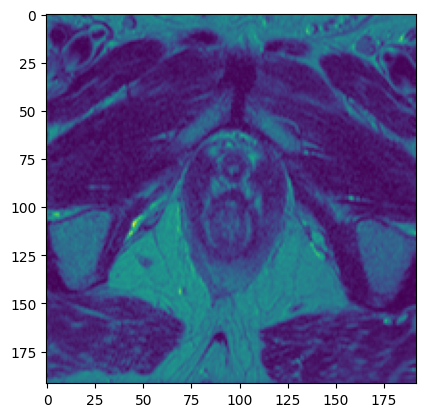

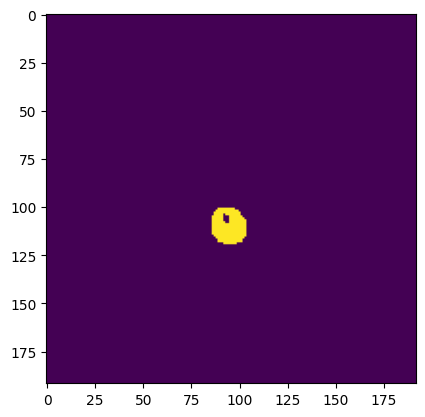

Provided binary mask


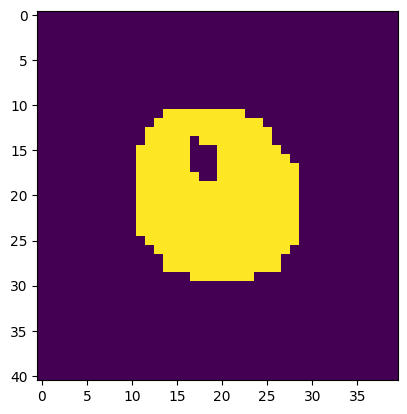

Cropped Image shape: (41, 40)
	 Extracting intensity Features for provide single image slice:

Raw intensities

	Extracting requested features

Extracting single feature matrix
\n 	 Extracting Gray Level Statistics:

	 Using a window size of  3 

:::::::::::::::::::::::::
Calculating Mean Image.

Calculating Median Image.

Calculating std Image.

Calculating Windowed range image.


	Extracting requested features

Extracting single feature matrix

Extracting Haralick-based (GLCM) features:


 	 using a distance of: 3 uint8
[[ 3.48065801e-04  1.09792749e+04 -3.00885681e-02  5.32928683e+03
   8.65367158e-03  2.54210943e+02  1.03378724e+04  8.42482835e+00
   1.15109737e+01  7.66823955e-06  7.58793542e+00 -5.38428413e-01
   9.99896315e-01]
 [ 3.80152931e-04  1.08789040e+04 -1.72840446e-02  5.34703362e+03
   1.25018460e-02  2.53059033e+02  1.05092305e+04  8.38905259e+00
   1.13906989e+01  7.95143804e-06  7.58263787e+00 -5.52302568e-01
   9.99915967e-01]
 [ 3.48208102e-04  1.13299724e+04 -6.0

In [ ]:
print(np.shape(mat))
print(mat.keys())
matImage=mat['vol']
matMask=mat['mask']
print(np.shape(matImage))
print(matImage[:,:,0])
plt.imshow(matImage[:,:,0])
plt.show()
plt.imshow(matMask[:,:,0])
plt.show()
extract2DFeatureInfo(matImage[:,:,0],matMask[:,:,0])

In [4]:
import numpy as np
q=np.array([[1,2,3,13],[4,5,6,14],[7,8,9,15],[16,17,18,19]])
print(q)
y=np.reshape(q,(2,8))
print(y)

[[ 1  2  3 13]
 [ 4  5  6 14]
 [ 7  8  9 15]
 [16 17 18 19]]
[[ 1  2  3 13  4  5  6 14]
 [ 7  8  9 15 16 17 18 19]]
